**Dataset Analysis**

In [ ]:
import pandas as pd

In [ ]:
# Load data
calls = pd.read_csv("/content/calls.csv")
reason = pd.read_csv("/content/reason.csv")
sentiment = pd.read_csv("/content/sentiment_statistics.csv")

In [ ]:
# Merge data
data = calls.merge(reason, on="call_id").merge(sentiment, on="call_id")
data.head()

,call_id,customer_id,agent_id_x,call_start_datetime,agent_assigned_datetime,call_end_datetime,call_transcript,primary_call_reason,agent_id_y,agent_tone,customer_tone,average_sentiment,silence_percent_average
0,4667960400,2033123310,963118,7/31/2024 23:56,8/1/2024 0:03,8/1/2024 0:34,\n\nAgent: Thank you for calling United Airlin...,Voluntary Cancel,963118,neutral,angry,-0.04,0.39
1,1122072124,8186702651,519057,8/1/2024 0:03,8/1/2024 0:06,8/1/2024 0:18,\n\nAgent: Thank you for calling United Airlin...,Booking,519057,calm,neutral,0.02,0.35
2,6834291559,2416856629,158319,7/31/2024 23:59,8/1/2024 0:07,8/1/2024 0:26,\n\nAgent: Thank you for calling United Airlin...,IRROPS,158319,neutral,polite,-0.13,0.32
3,2266439882,1154544516,488324,8/1/2024 0:05,8/1/2024 0:10,8/1/2024 0:17,\n\nAgent: Thank you for calling United Airlin...,Upgrade,488324,neutral,frustrated,-0.20,0.20
4,1211603231,5214456437,721730,8/1/2024 0:04,8/1/2024 0:14,8/1/2024 0:23,\n\nAgent: Thank you for calling United Airlin...,Seating,721730,neutral,polite,-0.05,0.35


**Calculate AHT and AST**

In [ ]:
# Calculate AHT and AST
data['aht'] = (pd.to_datetime(data['call_end_datetime']) - pd.to_datetime(data['agent_assigned_datetime'])).dt.total_seconds()
data['ast'] = (pd.to_datetime(data['agent_assigned_datetime']) - pd.to_datetime(data['call_start_datetime'])).dt.total_seconds()

In [ ]:
data['agent_id'] = data['agent_id_x'].combine_first(data['agent_id_y'])
data.drop(columns=['agent_id_y'], inplace=True)
data.drop(columns=['agent_id_x'], inplace=True)

In [ ]:
data.head()

,call_id,customer_id,call_start_datetime,agent_assigned_datetime,call_end_datetime,call_transcript,primary_call_reason,agent_tone,customer_tone,average_sentiment,silence_percent_average,aht,ast,agent_id
0,4667960400,2033123310,7/31/2024 23:56,8/1/2024 0:03,8/1/2024 0:34,\n\nAgent: Thank you for calling United Airlin...,Voluntary Cancel,neutral,angry,-0.04,0.39,1860.0,420.0,963118
1,1122072124,8186702651,8/1/2024 0:03,8/1/2024 0:06,8/1/2024 0:18,\n\nAgent: Thank you for calling United Airlin...,Booking,calm,neutral,0.02,0.35,720.0,180.0,519057
2,6834291559,2416856629,7/31/2024 23:59,8/1/2024 0:07,8/1/2024 0:26,\n\nAgent: Thank you for calling United Airlin...,IRROPS,neutral,polite,-0.13,0.32,1140.0,480.0,158319
3,2266439882,1154544516,8/1/2024 0:05,8/1/2024 0:10,8/1/2024 0:17,\n\nAgent: Thank you for calling United Airlin...,Upgrade,neutral,frustrated,-0.20,0.20,420.0,300.0,488324
4,1211603231,5214456437,8/1/2024 0:04,8/1/2024 0:14,8/1/2024 0:23,\n\nAgent: Thank you for calling United Airlin...,Seating,neutral,polite,-0.05,0.35,540.0,600.0,721730


In [ ]:
# Average AHT and AST by agent
agent_performance = data.groupby('agent_id').agg(avg_aht=('aht', 'mean'), avg_ast=('ast', 'mean')).reset_index()

In [ ]:
# Average AHT and AST by call reason
reason_performance = data.groupby('primary_call_reason').agg(
    avg_aht=('aht', 'mean'), count=('call_id', 'count')
).reset_index()

In [ ]:
# Identify the most and least frequent call reasons
most_frequent_reason = reason_performance.sort_values(by='count', ascending=False).iloc[0]
least_frequent_reason = reason_performance.sort_values(by='count').iloc[0]

In [ ]:
# Calculate percentage difference in AHT
percent_diff = ((most_frequent_reason['avg_aht'] - least_frequent_reason['avg_aht']) / least_frequent_reason['avg_aht']) * 100

In [ ]:
print(f"Percentage difference in AHT between most and least frequent call reasons: {percent_diff:.2f}%")

Percentage difference in AHT between most and least frequent call reasons: 336.38%


**self-service issues**

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

In [ ]:
calls = pd.read_csv("/content/calls.csv")
transcripts = calls[['call_id', 'call_transcript']]

In [ ]:
# Create a simple keyword list for common self-service issues
self_service_keywords = [
    'check status', 'reset password', 'change flight',
    'cancel flight', 'update payment', 'booking confirmation'
]

In [ ]:
# Create a CountVectorizer to analyze call transcripts
vectorizer = CountVectorizer(vocabulary=self_service_keywords)
X = vectorizer.fit_transform(transcripts['call_transcript'].astype(str))


In [ ]:
# Sum occurrences of each keyword
keyword_counts = np.array(X.sum(axis=0)).flatten()

In [ ]:
# Create a DataFrame to show the counts of self-service issues
self_service_df = pd.DataFrame({
    'Issue': self_service_keywords,
    'Count': keyword_counts
})

In [ ]:
# Filter for significant self-service issues
significant_issues = self_service_df[self_service_df['Count'] > 0].sort_values(by='Count', ascending=False)

In [ ]:
# Display significant self-service issues
print(significant_issues)

Empty DataFrame
Columns: [Issue, Count]
Index: []


**Primary Call Reasons**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import numpy as np

In [ ]:
# Load the datasets
calls = pd.read_csv("/content/calls.csv")
reasons = pd.read_csv("/content/reason.csv")
customers = pd.read_csv("/content/customers.csv")

In [ ]:
# Merge datasets
data = calls.merge(reasons, on="call_id").merge(customers, on="customer_id")

In [ ]:
# Data Cleaning: Handling missing values
data.dropna(subset=['call_transcript', 'primary_call_reason'], inplace=True)

<Axes: xlabel='primary_call_reason'>

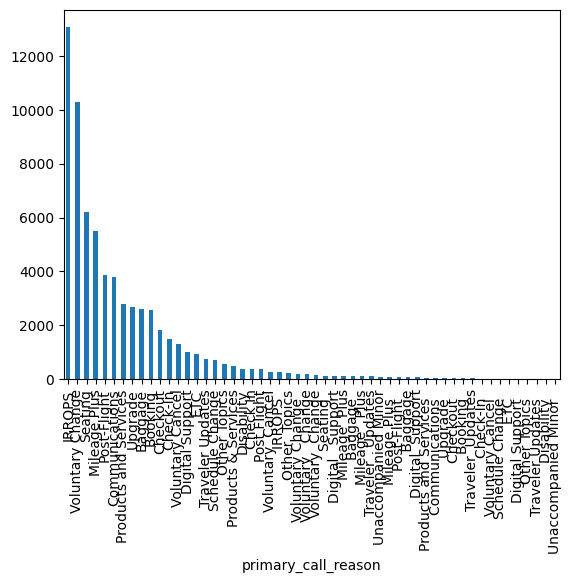

In [ ]:
# EDA: Visualizing call reasons
call_reason_counts = data['primary_call_reason'].value_counts()
call_reason_counts.plot(kind='bar')

**model performance**

In [ ]:
# Feature Engineering
# Create features for model training
X = data['call_transcript']  # Text data
y = data['primary_call_reason']  # Target labels

In [ ]:
# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Text Vectorization and Model Pipeline
pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

In [ ]:
# Train the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('classifier', RandomForestClassifier(random_state=42))])

In [ ]:
# Predicting on test set
y_pred = pipeline.predict(X_test)

In [ ]:
# Evaluate model performance
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                         precision    recall  f1-score   support

                Baggage       0.00      0.00      0.00        21
                Baggage       0.00      0.00      0.00       554
              Baggage         0.00      0.00      0.00        29
                Booking       0.00      0.00      0.00       497
              Booking         0.00      0.00      0.00        16
               Check In       0.00      0.00      0.00        76
               Check-In       0.00      0.00      0.00       276
             Check-In         0.00      0.00      0.00         7
               Checkout       0.00      0.00      0.00       373
             Checkout         0.00      0.00      0.00        11
         Communications       0.00      0.00      0.00       746
       Communications         0.00      0.00      0.00        11
      Digital   Support       0.00      0.00      0.00        32
       Digital  Support       0.00      0.00      0.00        19
        Digital Support 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Predictions on test.csv
test_data = pd.read_csv("/content/test.csv")

In [ ]:
# Create submission DataFrame
submission_df = pd.DataFrame({
    'call_id': test_data['call_id'],
})

In [ ]:
# Save to CSV
submission_df.to_csv("test_new.csv", index=False)

**Dataset Analysis**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

In [ ]:
# Download NLTK resources (if needed)
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Load the datasets
calls = pd.read_csv("/content/calls.csv")
reasons = pd.read_csv("/content/reason.csv")
customers = pd.read_csv("/content/customers.csv")

In [ ]:
# Data Overview
print("Calls Data Overview:")
print(calls.info())
print(calls.head())

Calls Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71810 entries, 0 to 71809
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   call_id                  71810 non-null  int64 
 1   customer_id              71810 non-null  int64 
 2   agent_id                 71810 non-null  int64 
 3   call_start_datetime      71810 non-null  object
 4   agent_assigned_datetime  71810 non-null  object
 5   call_end_datetime        71810 non-null  object
 6   call_transcript          71810 non-null  object
dtypes: int64(3), object(4)
memory usage: 3.8+ MB
None
      call_id  customer_id  agent_id call_start_datetime  \
0  4667960400   2033123310    963118     7/31/2024 23:56   
1  1122072124   8186702651    519057       8/1/2024 0:03   
2  6834291559   2416856629    158319     7/31/2024 23:59   
3  2266439882   1154544516    488324       8/1/2024 0:05   
4  1211603231   5214456437    721730   

In [ ]:
print("\nCustomers Data Overview:")
print(customers.info())
print(customers.head())


Customers Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71810 entries, 0 to 71809
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       71810 non-null  int64  
 1   customer_name     71810 non-null  object 
 2   elite_level_code  46043 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.6+ MB
None
   customer_id      customer_name  elite_level_code
0   2033123310     Matthew Foster               4.0
1   8186702651      Tammy Walters               NaN
2   2416856629      Jeffery Dixon               NaN
3   1154544516      David Wilkins               2.0
4   5214456437  Elizabeth Daniels               0.0


In [ ]:
print("\nReasons Data Overview:")
print(reasons.info())
print(reasons.head())


Reasons Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66653 entries, 0 to 66652
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   call_id              66653 non-null  int64 
 1   primary_call_reason  66653 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.0+ MB
None
      call_id primary_call_reason
0  4667960400   Voluntary  Cancel
1  1122072124             Booking
2  6834291559              IRROPS
3  2266439882             Upgrade
4  1211603231             Seating


In [ ]:
# Merge datasets
data = calls.merge(reasons, on="call_id").merge(customers, on="customer_id")

**Data Cleaning**

In [ ]:
# Data Cleaning
print("\nMissing Values in Merged Data:")
print(data.isnull().sum())
data.dropna(subset=['call_transcript', 'primary_call_reason'], inplace=True)


Missing Values in Merged Data:
call_id                        0
customer_id                    0
agent_id                       0
call_start_datetime            0
agent_assigned_datetime        0
call_end_datetime              0
call_transcript                0
primary_call_reason            0
customer_name                  0
elite_level_code           23959
dtype: int64


**Distribution of Primary Calls Reasons**

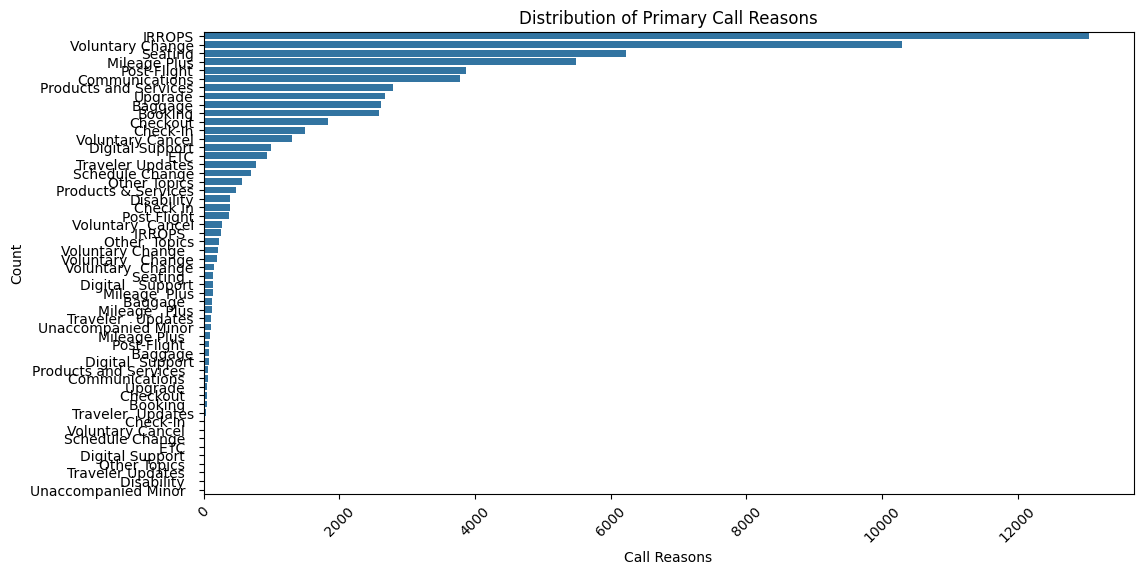

In [ ]:
# EDA: Visualize call reasons
plt.figure(figsize=(12, 6))
sns.countplot(data['primary_call_reason'], order=data['primary_call_reason'].value_counts().index)
plt.title('Distribution of Primary Call Reasons')
plt.xticks(rotation=45)
plt.xlabel('Call Reasons')
plt.ylabel('Count')
plt.show()

**Average Handle Time By Call Reasons**

In [ ]:
import pandas as pd

In [ ]:
calls = pd.read_csv("/content/calls.csv")
reason = pd.read_csv("/content/reason.csv")
sentiment = pd.read_csv("/content/sentiment_statistics.csv")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Merge datasets where appropriate
data = pd.merge(calls, reason, on="call_id", how="left")
data = pd.merge(data, sentiment, on="call_id", how="left")

# Convert date columns to datetime format with error handling
data['call_start_datetime'] = pd.to_datetime(data['call_start_datetime'], errors='coerce')
data['agent_assigned_datetime'] = pd.to_datetime(data['agent_assigned_datetime'], errors='coerce')
data['call_end_datetime'] = pd.to_datetime(data['call_end_datetime'], errors='coerce')

# Calculate call_duration in seconds, ignoring rows with missing datetime values
data['call_duration'] = (data['call_end_datetime'] - data['agent_assigned_datetime']).dt.total_seconds()


<ipython-input-18-b5b0d6dab629>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='primary_call_reason', y='call_duration', data=aht_by_reason, palette='viridis')
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarni

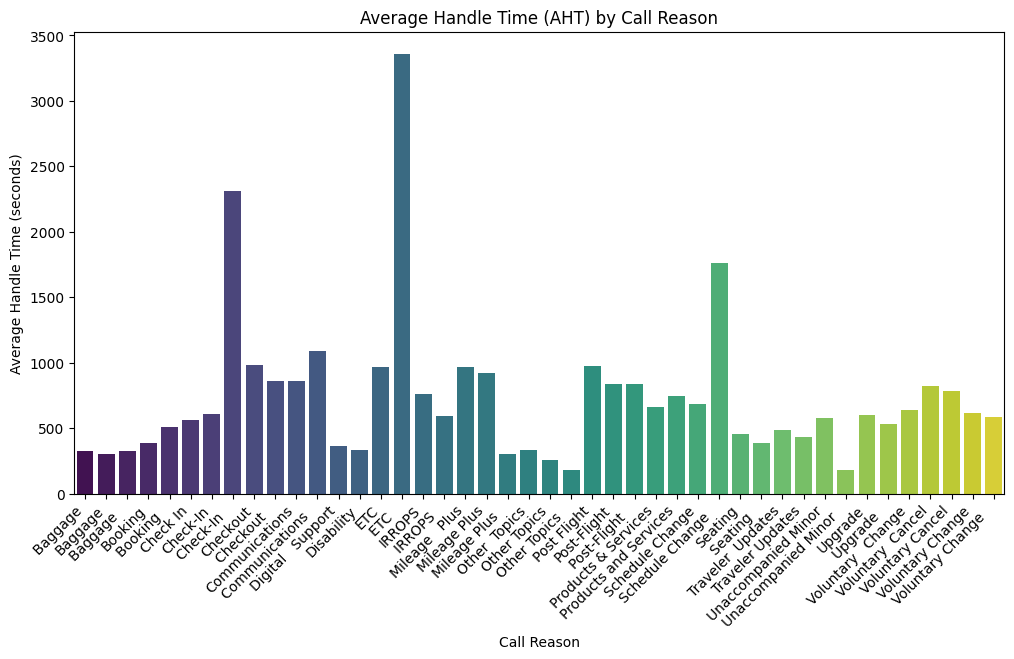

In [ ]:
# Calculate average handle time by call reason
aht_by_reason = data.groupby('primary_call_reason')['call_duration'].mean().reset_index()

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='primary_call_reason', y='call_duration', data=aht_by_reason, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title("Average Handle Time (AHT) by Call Reason")
plt.xlabel("Call Reason")
plt.ylabel("Average Handle Time (seconds)")
plt.show()

**Average Speed to Answer By Hour of the Day**

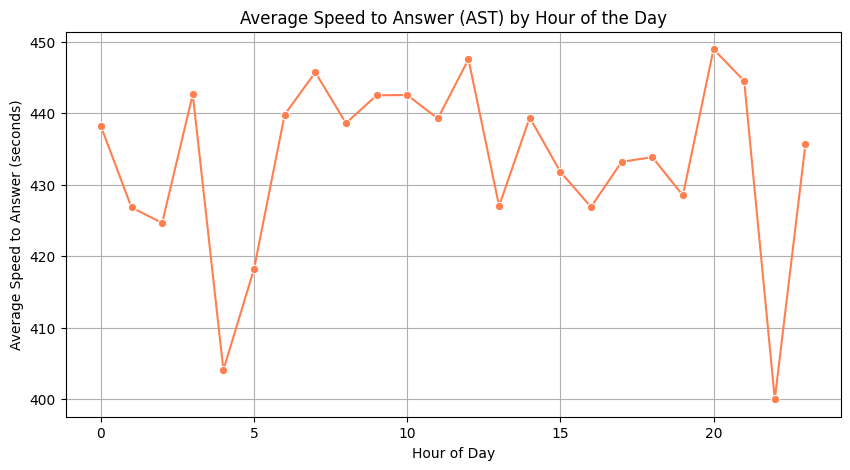

In [ ]:
# Calculate waiting time before agent assignment
data['waiting_time'] = (data['agent_assigned_datetime'] - data['call_start_datetime']).dt.total_seconds()

# Add hour of day for call start
data['call_hour'] = data['call_start_datetime'].dt.hour

# Calculate AST by hour
ast_by_hour = data.groupby('call_hour')['waiting_time'].mean().reset_index()

# Plot
plt.figure(figsize=(10, 5))
sns.lineplot(x='call_hour', y='waiting_time', data=ast_by_hour, marker="o", color="coral")
plt.title("Average Speed to Answer (AST) by Hour of the Day")
plt.xlabel("Hour of Day")
plt.ylabel("Average Speed to Answer (seconds)")
plt.grid()
plt.show()


**Call Volume By Day of the Week**

<ipython-input-20-bebd0952308f>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=call_volume_by_day.index, y=call_volume_by_day.values, palette="coolwarm")
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: Wh

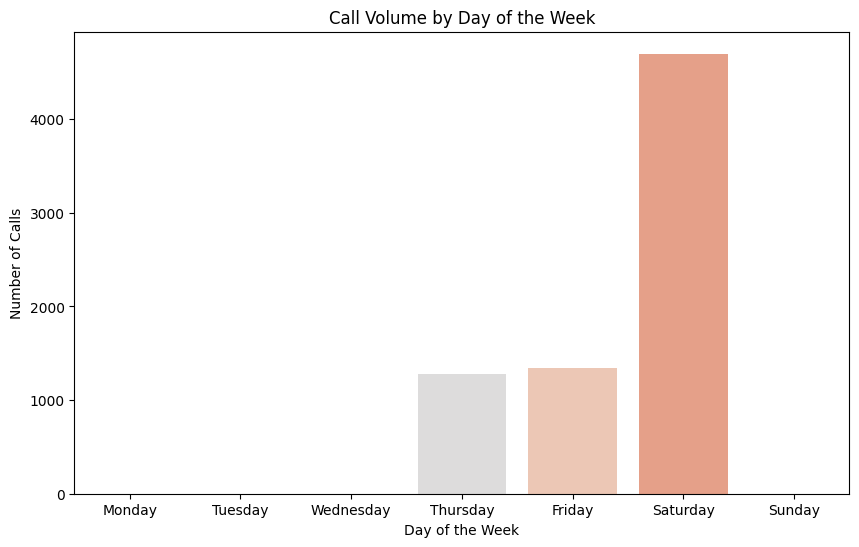

In [ ]:
# Add day of the week for call start
data['call_day'] = data['call_start_datetime'].dt.day_name()

# Calculate call volume by day of the week
call_volume_by_day = data['call_day'].value_counts().reindex(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=call_volume_by_day.index, y=call_volume_by_day.values, palette="coolwarm")
plt.title("Call Volume by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Number of Calls")
plt.show()

**Agent Tone vs Customer Tone By Call Reason**

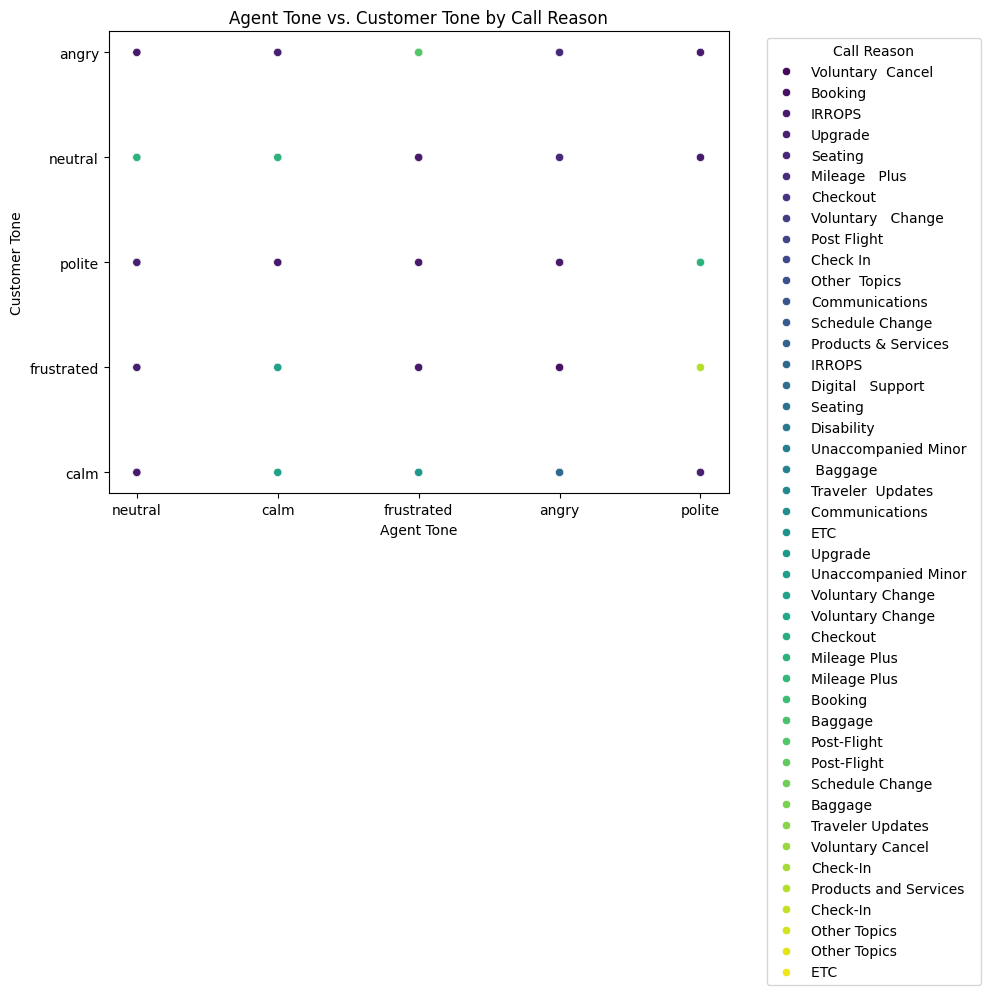

In [ ]:
# Scatter plot of agent vs. customer tone
plt.figure(figsize=(8, 6))
sns.scatterplot(x='agent_tone', y='customer_tone', data=data, hue='primary_call_reason', palette='viridis')
plt.title("Agent Tone vs. Customer Tone by Call Reason")
plt.xlabel("Agent Tone")
plt.ylabel("Customer Tone")
plt.legend(title='Call Reason', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


**Distribution of silence in Calls**

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


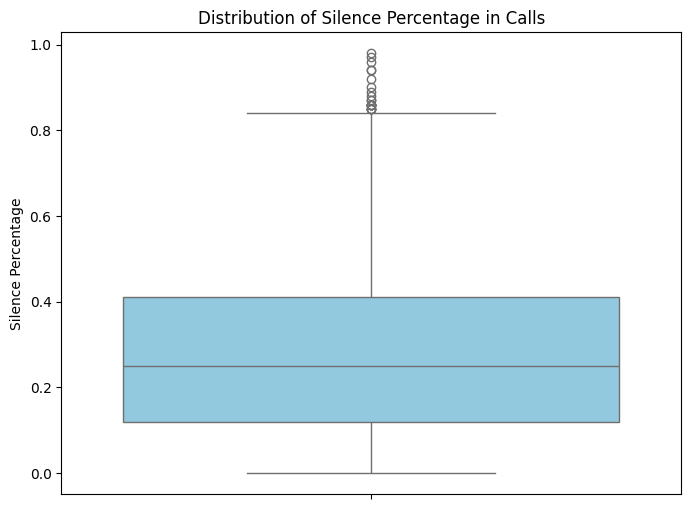

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(y='silence_percent_average', data=data, color="skyblue")
plt.title("Distribution of Silence Percentage in Calls")
plt.ylabel("Silence Percentage")
plt.show()


**Most vs Least Frequent Call Reasons**

<ipython-input-23-7c7da3127c2f>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Call Reason", y="Average Handle Time (seconds)", data=aht_data, palette="viridis")
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


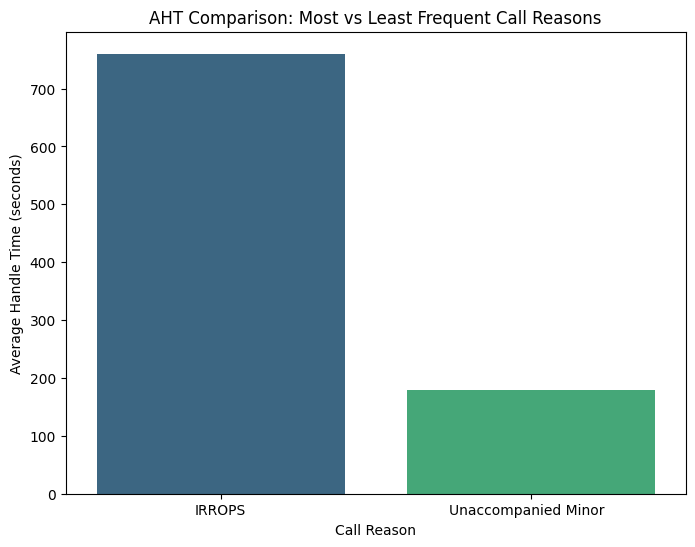

In [ ]:
# Get frequency of each call reason
reason_counts = data['primary_call_reason'].value_counts()

# Identify the most and least frequent call reasons
most_frequent_reason = reason_counts.idxmax()
least_frequent_reason = reason_counts.idxmin()

# Calculate average handle time (AHT) for most and least frequent call reasons
aht_most_frequent = data[data['primary_call_reason'] == most_frequent_reason]['call_duration'].mean()
aht_least_frequent = data[data['primary_call_reason'] == least_frequent_reason]['call_duration'].mean()

# Prepare data for plotting
aht_data = pd.DataFrame({
    "Call Reason": [most_frequent_reason, least_frequent_reason],
    "Average Handle Time (seconds)": [aht_most_frequent, aht_least_frequent]
})

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(x="Call Reason", y="Average Handle Time (seconds)", data=aht_data, palette="viridis")
plt.title("AHT Comparison: Most vs Least Frequent Call Reasons")
plt.xlabel("Call Reason")
plt.ylabel("Average Handle Time (seconds)")
plt.show()

**Distribution of Primary Call Reasons**

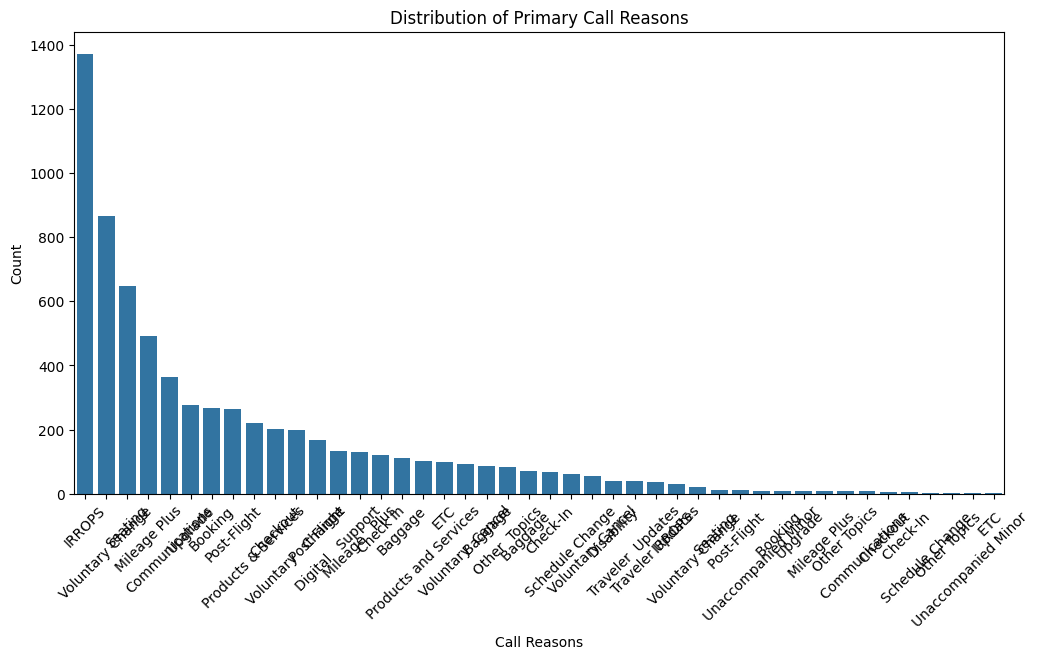

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(data=data, x='primary_call_reason', order=data['primary_call_reason'].value_counts().index)
plt.title('Distribution of Primary Call Reasons')
plt.xticks(rotation=45)
plt.xlabel('Call Reasons')
plt.ylabel('Count')
plt.show()

**Distribution of Call Durations**

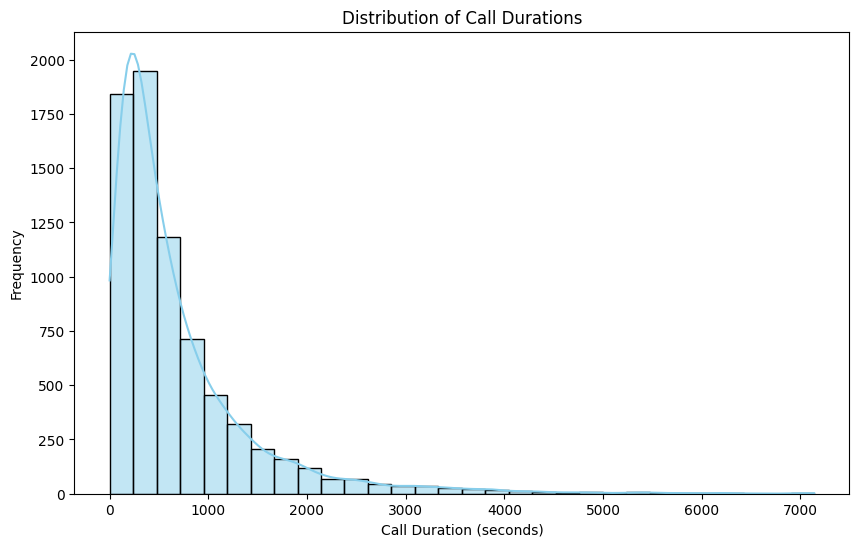

In [ ]:
data = pd.merge(calls, reason, on="call_id", how="left")

# Convert date-time columns to datetime format, handling errors by setting invalid dates to NaT
data['call_start_datetime'] = pd.to_datetime(data['call_start_datetime'], errors='coerce')
data['agent_assigned_datetime'] = pd.to_datetime(data['agent_assigned_datetime'], errors='coerce')
data['call_end_datetime'] = pd.to_datetime(data['call_end_datetime'], errors='coerce')

# Drop rows where call duration cannot be computed due to missing date values
data.dropna(subset=['call_start_datetime', 'agent_assigned_datetime', 'call_end_datetime'], inplace=True)

# Calculate call duration in seconds
data['call_duration'] = (data['call_end_datetime'] - data['agent_assigned_datetime']).dt.total_seconds()

# Plot distribution of call durations
plt.figure(figsize=(10, 6))
sns.histplot(data['call_duration'], bins=30, kde=True, color="skyblue")
plt.title("Distribution of Call Durations")
plt.xlabel("Call Duration (seconds)")
plt.ylabel("Frequency")
plt.show()

<ipython-input-34-b9b85562e294>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='agent_id', y='call_duration', data=aht_by_agent, palette="viridis")
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When gro

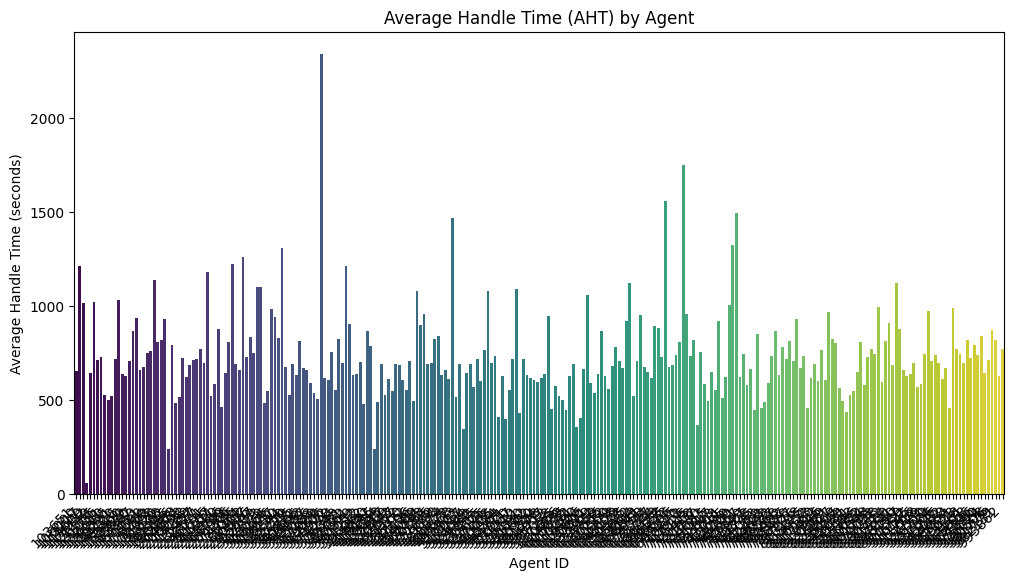

In [ ]:
# Calculate AHT by agent
aht_by_agent = data.groupby('agent_id')['call_duration'].mean().reset_index()

# Plot AHT by agent
plt.figure(figsize=(12, 6))
sns.barplot(x='agent_id', y='call_duration', data=aht_by_agent, palette="viridis")
plt.title("Average Handle Time (AHT) by Agent")
plt.xlabel("Agent ID")
plt.ylabel("Average Handle Time (seconds)")
plt.xticks(rotation=45, ha="right")
plt.show()

**Call Reason Distribution Pie Chart**

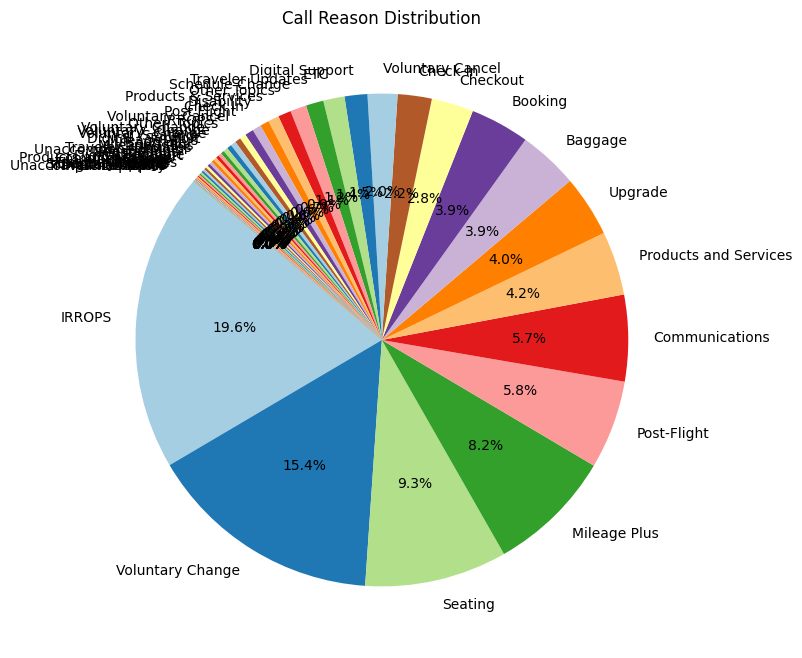

In [45]:
import matplotlib.pyplot as plt
import pandas as pd

# Load and merge datasets
calls = pd.read_csv("/content/calls.csv")
reasons = pd.read_csv("/content/reason.csv")
data = pd.merge(calls, reasons, on="call_id", how="left")

# Calculate distribution of call reasons
call_reason_counts = data['primary_call_reason'].value_counts()

# Plot pie chart
plt.figure(figsize=(8,8))
plt.pie(call_reason_counts, labels=call_reason_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title("Call Reason Distribution")
plt.show()

**Agent Tone Distribution**

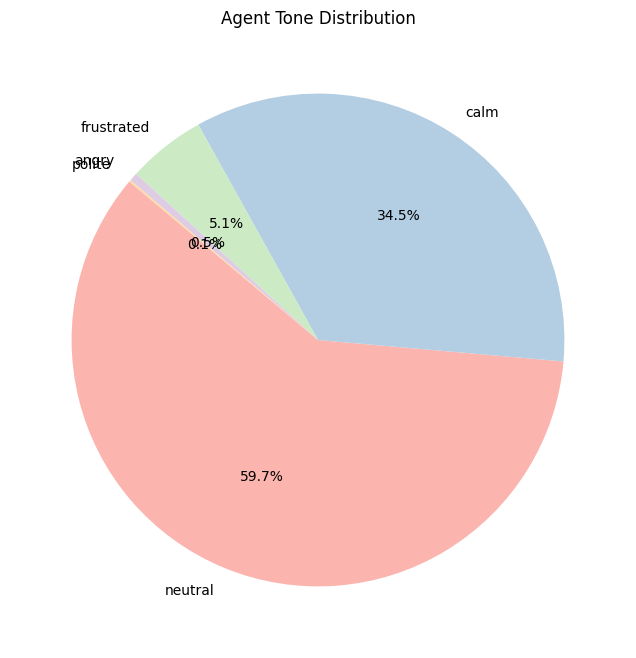

In [49]:
# Count each agent tone
sentiment_statistics = pd.read_csv("/content/sentiment_statistics.csv")
agent_tone_counts = sentiment_statistics['agent_tone'].value_counts()

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(agent_tone_counts, labels=agent_tone_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Pastel1.colors)
plt.title("Agent Tone Distribution")
plt.show()


**Call Duration Categories**

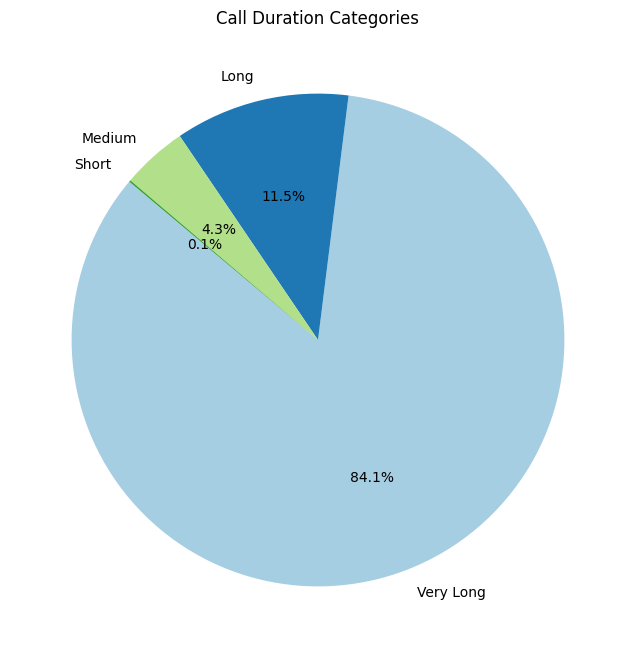

  call_start_datetime   call_end_datetime  total_call_duration  \
0 2024-07-31 23:56:00 2024-08-01 00:34:00               2280.0   
1 2024-08-01 00:03:00 2024-08-01 00:18:00                900.0   
2 2024-07-31 23:59:00 2024-08-01 00:26:00               1620.0   
3 2024-08-01 00:05:00 2024-08-01 00:17:00                720.0   
4 2024-08-01 00:04:00 2024-08-01 00:23:00               1140.0   

  duration_category  
0         Very Long  
1         Very Long  
2         Very Long  
3         Very Long  
4         Very Long  


In [51]:
# Convert datetime columns to datetime type
calls['call_start_datetime'] = pd.to_datetime(calls['call_start_datetime'])
calls['call_end_datetime'] = pd.to_datetime(calls['call_end_datetime'])

# Calculate total call duration in seconds
calls['total_call_duration'] = (calls['call_end_datetime'] - calls['call_start_datetime']).dt.total_seconds()

# Define duration categories in seconds
bins = [0, 180, 360, 540, calls['total_call_duration'].max()]  # Short (<3 min), Medium (3-6 min), Long (6-9 min), Very Long (>9 min)
labels = ['Short', 'Medium', 'Long', 'Very Long']

# Categorize call durations
calls['duration_category'] = pd.cut(calls['total_call_duration'], bins=bins, labels=labels)

# Count each duration category
duration_counts = calls['duration_category'].value_counts()

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(duration_counts, labels=duration_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title("Call Duration Categories")
plt.show()

# Display the first few rows of the dataset to verify calculations
print(calls[['call_start_datetime', 'call_end_datetime', 'total_call_duration', 'duration_category']].head())
